Author : Jacques Ding

Contact : ding@apc.in2p3.fr

Measurements in logbook entries 60019 & 59539. Noise injected in SSFS_err


We need to consider the following sources of coupling between the two arms of the ITF:
1. Radiation pressure
2. Schnupp asymmetry
3. BS transmission imbalance
4. BS AR reflectivity imbalance
5. CP loss imbalance
6. Input mirror AR loss imbalance
7. Input mirror HR transmisison imbalance
8. Arm length diff
9. CP + input mirror imbalance
10. Radiation pressure + CP + input at the dip
11. Realistic model with all losses.

In [31]:
import finesse.virgo
import pandas as pd

from finesse.analysis.actions import RunLocks, CheckLinearity, GetErrorSignals, DragLocks
from finesse.virgo.actions import DARM_RF_to_DC
from finesse.analysis.actions import (
    Series,
    RunLocks,
    Change,
    SensingMatrixDC,
    Minimize,
    Maximize,
    TemporaryParameters,
    OptimiseRFReadoutPhaseDC,
    Xaxis,
    Noxaxis,
    Temporary,
    FrequencyResponse,
    Noxaxis
)
from finesse.utilities.tables import Table, NumberTable



import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

from scipy.optimize import fsolve, brentq

finesse.init_plotting()
finesse.configure(progress_bars=True)

In [32]:
#Print powers with sidebands
def get_powers_with_rf(self):
        """Return a dictionary of carrier powers keyed by detector."""

        # run the model without modulation to get the carrier powers
        out = self.model.run(
            #Series(
            #    Temporary(
            #        Change(
            #            {
            #               "eom8.midx": 0,
            #               "eom6.midx": 0,
            #               "eom56.midx": 0,
            #           }
            #       ),
                    Noxaxis(),
            #   )
        #)
        )

        powers = {}
        for detector in self.model.detectors:
            # only grab output for carrier detectors
            if "CAR_AMP" in detector.name:
                power = np.abs(out[detector]) ** 2
                ratio = power / self.model.i1.P
                powers[detector.name] = [power, ratio]
            elif "SC_AMP" in detector.name:
                power = np.abs(out[detector]) ** 2
                ratio = power / self.model.SC.P
                powers[detector.name] = [power, ratio]
            elif "B1" in detector.name:
                power = out[detector]
                ratio = power / self.model.i1.P
                powers[detector.name] = [power, ratio]
        return powers

    # TODO: add ability to provide list of detectors (handle ad or pd)?
    
def print_powers_with_rf(self):
    """Display a table listing the carrier powers and power ratios."""

    powers = get_powers_with_rf(self)

    table = NumberTable(
        list(powers.values()),
        colnames=["Detector", "Power [W]", "Pow. ratio"],
        rownames=list(powers.keys()),
        numfmt=["{:9.4g}", "{:9.4g}"],
        compact=True,
    )

    print(table)

def make(virgo_object, verbose=False, dc_lock=True):
        """Performs full make process.

        Parameters
        ----------
        dc_lock : bool, optional
            Set to false to skip the final step switching DARM to the DC lock.

        verbose : bool, optional
            If set, displays additional information.
        """

        # step 1: adjust the cavity lengths
        print("Adjusting recycling cavity lengths...")
        virgo_object.adjust_recycling_cavity_length("PRC", "lPRC", "lPOP_BS", verbose=verbose)
        virgo_object.adjust_recycling_cavity_length("SRC", "lSRC", "lsr", verbose=verbose)

        # step 2: pretune
        print("Pretuning...")
        virgo_object.pretune(verbose=verbose)

        # step 3: optimize demodulation phases
        print("Optimizing demodulation phases...")
        virgo_object.optimize_demodulation_phase(verbose=verbose)

        # step 4: optimize lock gains
        print("Optimizing lock gains...")
        virgo_object.optimize_lock_gains(verbose=verbose)

        # step 5: run RF locks
        print("Running RF locks...")
        if virgo_object.verbose:
            virgo_object.print_dofs("before locking")

        virgo_object.model.run(RunLocks(method="newton"))

        if virgo_object.verbose:
            virgo_object.print_dofs("after locking")

        # step 6: optionally switch to DC locks
        if dc_lock:
            print("Switching to DARM DC lock...")
            if virgo_object.verbose or verbose:
                virgo_object.print_dofs("before locking")
            
            virgo_object.model.DARM_dc_lock.disabled = False
            virgo_object.model.DARM_rf_lock.disabled = True

            #virgo_object.model.DARM.
            
            virgo_object.model.run(Runlocks)

            if virgo_object.verbose or verbose:
                virgo_object.print_dofs("after locking")

        print("Done.")

In [33]:
# Without any HOM
# Input power at 40W
# Control scheme different from the default file

virgo = finesse.virgo.Virgo(files_to_parse=['virgo_O4_config_noloss-freq.kat','virgo_new_locks_noloss_freq.kat'], display_plots = True,
                           maxtem = "off", verbose = True, parse_additional_katscript=False, add_locks = False,
                            control_scheme={
                "PRCL": ("B2_6", "I", None, 1e-12),
                "SRCL": ("B4_56", "Q", None, 50e-11),
                "DARM": ("B1p_56", "I", None, 1e-16),
                "CARM": ("B4_6", "I", None, 1e-14),
                "MICH": ("B4_56", "I", None, 1e-11),
            })

Parsed input files, virgo_O4_config_noloss-freq.kat, virgo_new_locks_noloss_freq.kat


In [34]:
virgo.model.i1.P = 25

In [35]:
# Add some common losses
virgo.model.NI.L = 50e-6
virgo.model.WI.L = 50e-6

In [36]:
virgo.make(dc_lock= True)

Adjusting recycling cavity lengths...
--  adjusting PRC length
    adjusting lPOP_BS.L by 0.0004736 m
--  adjusting SRC length
    adjusting lsr.L by 0.000883 m
Pretuning...
Optimizing demodulation phases...
--  Optimized demodulation phases:
    PRCL     B2_6_I    : phase=-87.5485
    SRCL     B4_56_Q   : phase=-11.4762
    DARM     B1p_56_I  : phase= 59.0533
    CARM     B4_6_I    : phase= -2.9658
    MICH     B4_56_I   : phase=-101.4762
--  Suggested lock gains:
    PRCL     B2_6_I    : 2.6832e-06
    SRCL     B4_56_Q   : 0.00042128
    DARM     B1p_56_I  :     135.47
    CARM     B4_6_I    :     8.0611
    MICH     B4_56_I   : 0.00080902
Optimizing lock gains...
--  Optimized lock gains:
    PRCL     B2_6_I    : -3.7269e+05
    SRCL     B4_56_Q   :    -2373.7
    DARM     B1p_56_I  : -0.0073816
    CARM     B4_6_I    :   -0.12405
    MICH     B4_56_I   :    -1236.1
Running RF locks...
--  DOFs before locking:
    PRCL: 0.0
    SRCL: 90.0
    DARM: 0.0
    CARM: 0.0
    MICH: 0.0


PRCL_lock ✗ SRCL_lock ✗ DARM_rf_lock ✗ CARM_lock ✗ MICH_lock ✗ |###| 10000/10000

--  DOFs after locking:
    PRCL: 0.0
    SRCL: 89.99999999999999
    DARM: 0.0
    CARM: 0.0
    MICH: 0.0
Switching to DARM DC lock...
--  DOFs before locking:
    PRCL: 0.0
    SRCL: 89.99999999999999
    DARM: 0.0
    CARM: 0.0
    MICH: 0.0


DARM_rf_lock ✗ |###################################################| 10000/10000

DARM_dc_lock ✗ |###################################################| 10000/10000

--  DOFs after locking:
    PRCL: 0.0
    SRCL: 89.99999999999999
    DARM: -0.0005863347394145225
    CARM: 0.0
    MICH: 0.0
Done.


In [37]:
virgo.print_tunings()
virgo.print_powers()
print_powers_with_rf(virgo)

┌───────────┬────────────┬──────────────┬──────────────┬──────────────┐
│ Optic/DOF │  phi [deg] │ dof.DC [deg] │ Tuning [deg] │  Tuning [pm] │
╞═══════════╪════════════╪══════════════╪══════════════╪══════════════╡
│ NE        │          0 │              │  0.000586335 │      1.73294 │
│ WE        │          0 │              │ -0.000586335 │     -1.73294 │
│ NI        │          0 │              │            0 │            0 │
│ WI        │          0 │              │            0 │            0 │
│ PR        │          0 │              │            0 │            0 │
│ SR        │          0 │              │          -90 │      -266000 │
│ PRCL      │            │            0 │              │              │
│ SRCL      │            │           90 │              │              │
│ DARM      │            │   -0.0005863 │              │              │
│ CARM      │            │            0 │              │              │
│ MICH      │            │            0 │              │        

Run the locks again to fix the working point

In [38]:
virgo.model.run(RunLocks(method = 'newton'))
virgo.print_tunings()
virgo.print_powers()
print_powers_with_rf(virgo)

PRCL_lock ✗ SRCL_lock ✗ DARM_dc_lock ✗ CARM_lock ✗ MICH_lock ✗ |###| 10000/10000

┌───────────┬────────────┬──────────────┬──────────────┬──────────────┐
│ Optic/DOF │  phi [deg] │ dof.DC [deg] │ Tuning [deg] │  Tuning [pm] │
╞═══════════╪════════════╪══════════════╪══════════════╪══════════════╡
│ NE        │          0 │              │  0.000586335 │      1.73294 │
│ WE        │          0 │              │ -0.000586335 │     -1.73294 │
│ NI        │          0 │              │            0 │            0 │
│ WI        │          0 │              │            0 │            0 │
│ PR        │          0 │              │            0 │            0 │
│ SR        │          0 │              │          -90 │      -266000 │
│ PRCL      │            │            0 │              │              │
│ SRCL      │            │           90 │              │              │
│ DARM      │            │   -0.0005863 │              │              │
│ CARM      │            │            0 │              │              │
│ MICH      │            │            0 │              │        

In [39]:
traces = {}

# Radiation pressure

In [40]:
#Radiation pressure
with virgo.model.temporary_parameters():

    virgo.model.i1.P = 25

    #Cancel the Schnup asymmetry
    virgo.model.lBS_CPN.L = virgo.model.lBS_CPW.L 
    virgo.model.sCPNsub.L = virgo.model.sCPWsub.L
    virgo.model.sCPN_NI.L = virgo.model.sCPW_WI.L
    virgo.model.sNIsub.L = virgo.model.sWIsub.L
    virgo.model.sBSsub1.L =0
    
    # Symmetrize the arm length
    virgo.model.LW.L = virgo.model.LN.L

    #virgo.model.run(RunLocks(method = "newton"))
    out = virgo.model.run("series(frequency_response(geomspace(1, 100k, 1000), [i1.frq, DARM.AC], B1.DC, name='freq'), noxaxis())")
    #out = virgo.model.run("series(frequency_response(geomspace(10, 12k, 100),  DARM, B1.DC, name='freq'), noxaxis())")

    traces['RP'] = out['freq']
    virgo.print_tunings()
    virgo.print_powers()

/Users/jacquesding/opt/anaconda3/lib/python3.8/site-packages/finesse/analysis/actions/base.py:133: UserWarning: Signal frequency (fsig) was set to None but simulation needs it. Setting default value of 1 Hz
  self.__sim.__enter__()


┌───────────┬────────────┬──────────────┬──────────────┬──────────────┐
│ Optic/DOF │  phi [deg] │ dof.DC [deg] │ Tuning [deg] │  Tuning [pm] │
╞═══════════╪════════════╪══════════════╪══════════════╪══════════════╡
│ NE        │          0 │              │  0.000586335 │      1.73294 │
│ WE        │          0 │              │ -0.000586335 │     -1.73294 │
│ NI        │          0 │              │            0 │            0 │
│ WI        │          0 │              │            0 │            0 │
│ PR        │          0 │              │            0 │            0 │
│ SR        │          0 │              │          -90 │      -266000 │
│ PRCL      │            │            0 │              │              │
│ SRCL      │            │           90 │              │              │
│ DARM      │            │   -0.0005863 │              │              │
│ CARM      │            │            0 │              │              │
│ MICH      │            │            0 │              │        

# Schnupp asymmetry


In [41]:
# Schnupp
with virgo.model.temporary_parameters():

    virgo.model.i1.P = 25
    
    #infinite mass of the mirrors
    virgo.model.WI_sus.mass = +np.inf
    virgo.model.WE_sus.mass = +np.inf
    virgo.model.NI_sus.mass = +np.inf
    virgo.model.NE_sus.mass = +np.inf
    
    #Cancel the Schnup asymmetry
    #virgo.model.lBS_CPN.L = virgo.model.lBS_CPW.L 
    #virgo.model.sCPNsub.L = virgo.model.sCPWsub.L
    #virgo.model.sCPN_NI.L = virgo.model.sCPW_WI.L
    #virgo.model.sNIsub.L = virgo.model.sWIsub.L
    #virgo.model.sBSsub1.L =0
    
    #Symmetrize the lengths
    virgo.model.LW.L = virgo.model.LN.L

    #virgo.model.run(RunLocks(method = "newton"))
    out = virgo.model.run("series(frequency_response(geomspace(1, 100k, 1000), [i1.frq, DARM.AC], B1.DC, name='freq'), noxaxis())")
    #out = virgo.model.run("series(frequency_response(geomspace(10, 12k, 100),  DARM, B1.DC, name='freq'), noxaxis())")

    traces['Schnupp'] = out['freq']
    virgo.print_tunings()
    virgo.print_powers()

/Users/jacquesding/opt/anaconda3/lib/python3.8/site-packages/finesse/analysis/actions/base.py:133: UserWarning: Signal frequency (fsig) was set to None but simulation needs it. Setting default value of 1 Hz
  self.__sim.__enter__()


┌───────────┬────────────┬──────────────┬──────────────┬──────────────┐
│ Optic/DOF │  phi [deg] │ dof.DC [deg] │ Tuning [deg] │  Tuning [pm] │
╞═══════════╪════════════╪══════════════╪══════════════╪══════════════╡
│ NE        │          0 │              │  0.000586335 │      1.73294 │
│ WE        │          0 │              │ -0.000586335 │     -1.73294 │
│ NI        │          0 │              │            0 │            0 │
│ WI        │          0 │              │            0 │            0 │
│ PR        │          0 │              │            0 │            0 │
│ SR        │          0 │              │          -90 │      -266000 │
│ PRCL      │            │            0 │              │              │
│ SRCL      │            │           90 │              │              │
│ DARM      │            │   -0.0005863 │              │              │
│ CARM      │            │            0 │              │              │
│ MICH      │            │            0 │              │        

# BS transmission imbalance

In [42]:
# BS diff loss
with virgo.model.temporary_parameters():

    virgo.model.i1.P = 25
    
    #infinite mass of the mirrors
    virgo.model.WI_sus.mass = +np.inf
    virgo.model.WE_sus.mass = +np.inf
    virgo.model.NI_sus.mass = +np.inf
    virgo.model.NE_sus.mass = +np.inf
    
    #Cancel the Schnup asymmetry
    virgo.model.lBS_CPN.L = virgo.model.lBS_CPW.L 
    virgo.model.sCPNsub.L = virgo.model.sCPWsub.L
    virgo.model.sCPN_NI.L = virgo.model.sCPW_WI.L
    virgo.model.sNIsub.L = virgo.model.sWIsub.L
    virgo.model.sBSsub1.L =0
    
    #Symmetrize the lengths
    virgo.model.LW.L = virgo.model.LN.L
    
    # Add some corner diff trans BS
    virgo.model.BS.T = 0.5+1e-3
    virgo.model.BS.R = 1-virgo.model.BS.T
    virgo.model.BS.L = 0 
    #virgo.model.run(RunLocks(method = "newton"))
    out = virgo.model.run("series(frequency_response(geomspace(1, 100k, 1000), [i1.frq, DARM.AC], B1.DC, name='freq'), noxaxis())")
    #out = virgo.model.run("series(frequency_response(geomspace(10, 12k, 100),  DARM, B1.DC, name='freq'), noxaxis())")

    traces['BS diff T'] = out['freq']
    virgo.print_tunings()
    virgo.print_powers()

/Users/jacquesding/opt/anaconda3/lib/python3.8/site-packages/finesse/analysis/actions/base.py:133: UserWarning: Signal frequency (fsig) was set to None but simulation needs it. Setting default value of 1 Hz
  self.__sim.__enter__()


┌───────────┬────────────┬──────────────┬──────────────┬──────────────┐
│ Optic/DOF │  phi [deg] │ dof.DC [deg] │ Tuning [deg] │  Tuning [pm] │
╞═══════════╪════════════╪══════════════╪══════════════╪══════════════╡
│ NE        │          0 │              │  0.000586335 │      1.73294 │
│ WE        │          0 │              │ -0.000586335 │     -1.73294 │
│ NI        │          0 │              │            0 │            0 │
│ WI        │          0 │              │            0 │            0 │
│ PR        │          0 │              │            0 │            0 │
│ SR        │          0 │              │          -90 │      -266000 │
│ PRCL      │            │            0 │              │              │
│ SRCL      │            │           90 │              │              │
│ DARM      │            │   -0.0005863 │              │              │
│ CARM      │            │            0 │              │              │
│ MICH      │            │            0 │              │        

# BS AR reflectivity imbalance

In [43]:
# BS diff loss
with virgo.model.temporary_parameters():

    virgo.model.i1.P = 25
    
    #infinite mass of the mirrors
    virgo.model.WI_sus.mass = +np.inf
    virgo.model.WE_sus.mass = +np.inf
    virgo.model.NI_sus.mass = +np.inf
    virgo.model.NE_sus.mass = +np.inf
    
    #Cancel the Schnup asymmetry
    virgo.model.lBS_CPN.L = virgo.model.lBS_CPW.L 
    virgo.model.sCPNsub.L = virgo.model.sCPWsub.L
    virgo.model.sCPN_NI.L = virgo.model.sCPW_WI.L
    virgo.model.sNIsub.L = virgo.model.sWIsub.L
    virgo.model.sBSsub1.L =0
    
    #Symmetrize the lengths
    virgo.model.LW.L = virgo.model.LN.L
    
    # Add some BS AR reflectivity difference, note that only the North beam passes through this AR coating
    
    virgo.model.BSAR1.R =  329e-6
    virgo.model.BSAR1.T = 1-virgo.model.BSAR1.R
    
    virgo.model.BSAR2.R =  329e-6
    virgo.model.BSAR2.T = 1-virgo.model.BSAR2.R
    
    #virgo.model.run(RunLocks(method = "newton"))
    out = virgo.model.run("series(frequency_response(geomspace(1, 100k, 1000), [i1.frq, DARM.AC], B1.DC, name='freq'), noxaxis())")
    #out = virgo.model.run("series(frequency_response(geomspace(10, 12k, 100),  DARM, B1.DC, name='freq'), noxaxis())")

    traces['BS AR'] = out['freq']
    virgo.print_tunings()
    virgo.print_powers()

/Users/jacquesding/opt/anaconda3/lib/python3.8/site-packages/finesse/analysis/actions/base.py:133: UserWarning: Signal frequency (fsig) was set to None but simulation needs it. Setting default value of 1 Hz
  self.__sim.__enter__()


┌───────────┬────────────┬──────────────┬──────────────┬──────────────┐
│ Optic/DOF │  phi [deg] │ dof.DC [deg] │ Tuning [deg] │  Tuning [pm] │
╞═══════════╪════════════╪══════════════╪══════════════╪══════════════╡
│ NE        │          0 │              │  0.000586335 │      1.73294 │
│ WE        │          0 │              │ -0.000586335 │     -1.73294 │
│ NI        │          0 │              │            0 │            0 │
│ WI        │          0 │              │            0 │            0 │
│ PR        │          0 │              │            0 │            0 │
│ SR        │          0 │              │          -90 │      -266000 │
│ PRCL      │            │            0 │              │              │
│ SRCL      │            │           90 │              │              │
│ DARM      │            │   -0.0005863 │              │              │
│ CARM      │            │            0 │              │              │
│ MICH      │            │            0 │              │        

# CP loss imbalance

The two interfaces of each compensation plate have different losses :
- 22u and 44 u for Narm
- 87u and 114u for Warm

-> difference of 135u

In [44]:
# CP loss imbalance
with virgo.model.temporary_parameters():

    virgo.model.i1.P = 25
    
    #infinite mass of the mirrors
    virgo.model.WI_sus.mass = +np.inf
    virgo.model.WE_sus.mass = +np.inf
    virgo.model.NI_sus.mass = +np.inf
    virgo.model.NE_sus.mass = +np.inf
    
    #Cancel the Schnup asymmetry
    virgo.model.lBS_CPN.L = virgo.model.lBS_CPW.L 
    virgo.model.sCPNsub.L = virgo.model.sCPWsub.L
    virgo.model.sCPN_NI.L = virgo.model.sCPW_WI.L
    virgo.model.sNIsub.L = virgo.model.sWIsub.L
    virgo.model.sBSsub1.L =0
    
    #Symmetrize the lengths
    virgo.model.LW.L = virgo.model.LN.L
    
    # Add some CP diff loss
    
    virgo.model.CPN1.R = 0
    virgo.model.CPN1.L = 66e-6
    virgo.model.CPN1.T = 1-virgo.model.CPN1.R - virgo.model.CPN1.L
    
    virgo.model.CPW1.R = 0
    virgo.model.CPW1.L = (97+114)*1e-6
    virgo.model.CPW1.T = 1-virgo.model.CPW1.R - virgo.model.CPW1.L
    
    #virgo.model.run(RunLocks(method = "newton"))
    out = virgo.model.run("series(frequency_response(geomspace(1, 100k, 1000), [i1.frq, DARM.AC], B1.DC, name='freq'), noxaxis())")
    #out = virgo.model.run("series(frequency_response(geomspace(10, 12k, 100),  DARM, B1.DC, name='freq'), noxaxis())")

    traces['CP'] = out['freq']
    virgo.print_tunings()
    virgo.print_powers()

/Users/jacquesding/opt/anaconda3/lib/python3.8/site-packages/finesse/analysis/actions/base.py:133: UserWarning: Signal frequency (fsig) was set to None but simulation needs it. Setting default value of 1 Hz
  self.__sim.__enter__()


┌───────────┬────────────┬──────────────┬──────────────┬──────────────┐
│ Optic/DOF │  phi [deg] │ dof.DC [deg] │ Tuning [deg] │  Tuning [pm] │
╞═══════════╪════════════╪══════════════╪══════════════╪══════════════╡
│ NE        │          0 │              │  0.000586335 │      1.73294 │
│ WE        │          0 │              │ -0.000586335 │     -1.73294 │
│ NI        │          0 │              │            0 │            0 │
│ WI        │          0 │              │            0 │            0 │
│ PR        │          0 │              │            0 │            0 │
│ SR        │          0 │              │          -90 │      -266000 │
│ PRCL      │            │            0 │              │              │
│ SRCL      │            │           90 │              │              │
│ DARM      │            │   -0.0005863 │              │              │
│ CARM      │            │            0 │              │              │
│ MICH      │            │            0 │              │        

# Input mirror AR loss imbalance

- 32u for NIAR
- 58u for WIAR

-> difference of 26u

In [45]:
# input mirror AR loss imbalance
with virgo.model.temporary_parameters():

    virgo.model.i1.P = 25
    
    #infinite mass of the mirrors
    virgo.model.WI_sus.mass = +np.inf
    virgo.model.WE_sus.mass = +np.inf
    virgo.model.NI_sus.mass = +np.inf
    virgo.model.NE_sus.mass = +np.inf
    
    #Cancel the Schnup asymmetry
    virgo.model.lBS_CPN.L = virgo.model.lBS_CPW.L 
    virgo.model.sCPNsub.L = virgo.model.sCPWsub.L
    virgo.model.sCPN_NI.L = virgo.model.sCPW_WI.L
    virgo.model.sNIsub.L = virgo.model.sWIsub.L
    virgo.model.sBSsub1.L =0
    
    #Symmetrize the lengths
    virgo.model.LW.L = virgo.model.LN.L
    
    # Add some CP diff loss
    
    virgo.model.NIAR.R = 32e-6
    virgo.model.NIAR.L = 0
    virgo.model.NIAR.T = 1-virgo.model.NIAR.R - virgo.model.NIAR.L
    
    virgo.model.WIAR.R = 58e-6
    virgo.model.WIAR.L = 0
    virgo.model.WIAR.T = 1-virgo.model.WIAR.R - virgo.model.WIAR.L
    
    #virgo.model.run(RunLocks(method = "newton"))
    out = virgo.model.run("series(frequency_response(geomspace(1, 100k, 1000), [i1.frq, DARM.AC], B1.DC, name='freq'), noxaxis())")
    #out = virgo.model.run("series(frequency_response(geomspace(10, 12k, 100),  DARM, B1.DC, name='freq'), noxaxis())")

    traces['Input AR'] = out['freq']
    virgo.print_tunings()
    virgo.print_powers()

/Users/jacquesding/opt/anaconda3/lib/python3.8/site-packages/finesse/analysis/actions/base.py:133: UserWarning: Signal frequency (fsig) was set to None but simulation needs it. Setting default value of 1 Hz
  self.__sim.__enter__()


┌───────────┬────────────┬──────────────┬──────────────┬──────────────┐
│ Optic/DOF │  phi [deg] │ dof.DC [deg] │ Tuning [deg] │  Tuning [pm] │
╞═══════════╪════════════╪══════════════╪══════════════╪══════════════╡
│ NE        │          0 │              │  0.000586335 │      1.73294 │
│ WE        │          0 │              │ -0.000586335 │     -1.73294 │
│ NI        │          0 │              │            0 │            0 │
│ WI        │          0 │              │            0 │            0 │
│ PR        │          0 │              │            0 │            0 │
│ SR        │          0 │              │          -90 │      -266000 │
│ PRCL      │            │            0 │              │              │
│ SRCL      │            │           90 │              │              │
│ DARM      │            │   -0.0005863 │              │              │
│ CARM      │            │            0 │              │              │
│ MICH      │            │            0 │              │        

# Input mirror HR transmission imbalance

- 1.377e-2 for NI
- 1.375e-2 for WI

-> difference of 20u

In [46]:
# Input HR diff
with virgo.model.temporary_parameters():

    virgo.model.i1.P = 25
    
    #infinite mass of the mirrors
    virgo.model.WI_sus.mass = +np.inf
    virgo.model.WE_sus.mass = +np.inf
    virgo.model.NI_sus.mass = +np.inf
    virgo.model.NE_sus.mass = +np.inf
    
    #Cancel the Schnup asymmetry
    virgo.model.lBS_CPN.L = virgo.model.lBS_CPW.L 
    virgo.model.sCPNsub.L = virgo.model.sCPWsub.L
    virgo.model.sCPN_NI.L = virgo.model.sCPW_WI.L
    virgo.model.sNIsub.L = virgo.model.sWIsub.L
    virgo.model.sBSsub1.L =0
    
    #Symmetrize the lengths
    virgo.model.LW.L = virgo.model.LN.L
    
    # Add some input mirror HR diff loss
    
    virgo.model.NI.T = 1.377e-2
    virgo.model.NI.L = 27e-6
    virgo.model.NI.R = 1-virgo.model.NI.T - virgo.model.NI.L
    
    virgo.model.WI.T = 1.375e-2
    virgo.model.WI.L = 27e-6
    virgo.model.WI.R = 1-virgo.model.WI.T - virgo.model.WI.L
    
    #virgo.model.run(RunLocks(method = "newton"))
    out = virgo.model.run("series(frequency_response(geomspace(1, 100k, 1000), [i1.frq, DARM.AC], B1.DC, name='freq'), noxaxis())")
    #out = virgo.model.run("series(frequency_response(geomspace(10, 12k, 100),  DARM, B1.DC, name='freq'), noxaxis())")

    traces['Input HR'] = out['freq']
    virgo.print_tunings()
    virgo.print_powers()

/Users/jacquesding/opt/anaconda3/lib/python3.8/site-packages/finesse/analysis/actions/base.py:133: UserWarning: Signal frequency (fsig) was set to None but simulation needs it. Setting default value of 1 Hz
  self.__sim.__enter__()


┌───────────┬────────────┬──────────────┬──────────────┬──────────────┐
│ Optic/DOF │  phi [deg] │ dof.DC [deg] │ Tuning [deg] │  Tuning [pm] │
╞═══════════╪════════════╪══════════════╪══════════════╪══════════════╡
│ NE        │          0 │              │  0.000586335 │      1.73294 │
│ WE        │          0 │              │ -0.000586335 │     -1.73294 │
│ NI        │          0 │              │            0 │            0 │
│ WI        │          0 │              │            0 │            0 │
│ PR        │          0 │              │            0 │            0 │
│ SR        │          0 │              │          -90 │      -266000 │
│ PRCL      │            │            0 │              │              │
│ SRCL      │            │           90 │              │              │
│ DARM      │            │   -0.0005863 │              │              │
│ CARM      │            │            0 │              │              │
│ MICH      │            │            0 │              │        

# Arm length diff

In [47]:
# Arm length difference
with virgo.model.temporary_parameters():

    virgo.model.i1.P = 25
    
    #infinite mass of the mirrors
    virgo.model.WI_sus.mass = +np.inf
    virgo.model.WE_sus.mass = +np.inf
    virgo.model.NI_sus.mass = +np.inf
    virgo.model.NE_sus.mass = +np.inf
    
    #Cancel the Schnup asymmetry
    virgo.model.lBS_CPN.L = virgo.model.lBS_CPW.L 
    virgo.model.sCPNsub.L = virgo.model.sCPWsub.L
    virgo.model.sCPN_NI.L = virgo.model.sCPW_WI.L
    virgo.model.sNIsub.L = virgo.model.sWIsub.L
    virgo.model.sBSsub1.L =0

    #virgo.model.run(RunLocks(method = "newton"))
    out = virgo.model.run("series(frequency_response(geomspace(1, 100k, 1000), [i1.frq, DARM.AC], B1.DC, name='freq'), noxaxis())")
    #out = virgo.model.run("series(frequency_response(geomspace(10, 12k, 100),  DARM, B1.DC, name='freq'), noxaxis())")

    traces['arm length diff'] = out['freq']
    virgo.print_tunings()
    virgo.print_powers()

/Users/jacquesding/opt/anaconda3/lib/python3.8/site-packages/finesse/analysis/actions/base.py:133: UserWarning: Signal frequency (fsig) was set to None but simulation needs it. Setting default value of 1 Hz
  self.__sim.__enter__()


┌───────────┬────────────┬──────────────┬──────────────┬──────────────┐
│ Optic/DOF │  phi [deg] │ dof.DC [deg] │ Tuning [deg] │  Tuning [pm] │
╞═══════════╪════════════╪══════════════╪══════════════╪══════════════╡
│ NE        │          0 │              │  0.000586335 │      1.73294 │
│ WE        │          0 │              │ -0.000586335 │     -1.73294 │
│ NI        │          0 │              │            0 │            0 │
│ WI        │          0 │              │            0 │            0 │
│ PR        │          0 │              │            0 │            0 │
│ SR        │          0 │              │          -90 │      -266000 │
│ PRCL      │            │            0 │              │              │
│ SRCL      │            │           90 │              │              │
│ DARM      │            │   -0.0005863 │              │              │
│ CARM      │            │            0 │              │              │
│ MICH      │            │            0 │              │        

# CP and Input mirror imbalance

Let us include both CP and Input mirror imbalances. Can the two effects
"compensate" each other to symmetrize the arms ?

In [48]:
with virgo.model.temporary_parameters():

    virgo.model.i1.P = 25
    
    #infinite mass of the mirrors
    virgo.model.WI_sus.mass = +np.inf
    virgo.model.WE_sus.mass = +np.inf
    virgo.model.NI_sus.mass = +np.inf
    virgo.model.NE_sus.mass = +np.inf
    
    #Cancel the Schnup asymmetry
    virgo.model.lBS_CPN.L = virgo.model.lBS_CPW.L 
    virgo.model.sCPNsub.L = virgo.model.sCPWsub.L
    virgo.model.sCPN_NI.L = virgo.model.sCPW_WI.L
    virgo.model.sNIsub.L = virgo.model.sWIsub.L
    virgo.model.sBSsub1.L =0
    
    #Symmetrize the lengths
    virgo.model.LW.L = virgo.model.LN.L
    
    # Add some CP diff loss
    
    virgo.model.NIAR.R = 32e-6
    virgo.model.NIAR.L = 0
    virgo.model.NIAR.T = 1-virgo.model.NIAR.R - virgo.model.NIAR.L
    
    virgo.model.WIAR.R = 58e-6
    virgo.model.WIAR.L = 0
    virgo.model.WIAR.T = 1-virgo.model.WIAR.R - virgo.model.WIAR.L
    
    # Add some input mirror HR diff loss
    
    virgo.model.NI.T = 1.377e-2
    virgo.model.NI.L = 27e-6
    virgo.model.NI.R = 1-virgo.model.NI.T - virgo.model.NI.L
    
    virgo.model.WI.T = 1.375e-2
    virgo.model.WI.L = 27e-6
    virgo.model.WI.R = 1-virgo.model.WI.T - virgo.model.WI.L
    
    #virgo.model.run(RunLocks(method = "newton"))
    out = virgo.model.run("series(frequency_response(geomspace(1, 100k, 1000), [i1.frq, DARM.AC], B1.DC, name='freq'), noxaxis())")
    #out = virgo.model.run("series(frequency_response(geomspace(10, 12k, 100),  DARM, B1.DC, name='freq'), noxaxis())")

    traces['CP + input'] = out['freq']
    virgo.print_tunings()
    virgo.print_powers()

/Users/jacquesding/opt/anaconda3/lib/python3.8/site-packages/finesse/analysis/actions/base.py:133: UserWarning: Signal frequency (fsig) was set to None but simulation needs it. Setting default value of 1 Hz
  self.__sim.__enter__()


┌───────────┬────────────┬──────────────┬──────────────┬──────────────┐
│ Optic/DOF │  phi [deg] │ dof.DC [deg] │ Tuning [deg] │  Tuning [pm] │
╞═══════════╪════════════╪══════════════╪══════════════╪══════════════╡
│ NE        │          0 │              │  0.000586335 │      1.73294 │
│ WE        │          0 │              │ -0.000586335 │     -1.73294 │
│ NI        │          0 │              │            0 │            0 │
│ WI        │          0 │              │            0 │            0 │
│ PR        │          0 │              │            0 │            0 │
│ SR        │          0 │              │          -90 │      -266000 │
│ PRCL      │            │            0 │              │              │
│ SRCL      │            │           90 │              │              │
│ DARM      │            │   -0.0005863 │              │              │
│ CARM      │            │            0 │              │              │
│ MICH      │            │            0 │              │        

# Radiation pressure + CP + input at the dip

In [50]:
with virgo.model.temporary_parameters():

    virgo.model.i1.P = 25
    
    #finite mass of the mirrors
    #virgo.model.WI_sus.mass = +np.inf
    #virgo.model.WE_sus.mass = +np.inf
    #virgo.model.NI_sus.mass = +np.inf
    #virgo.model.NE_sus.mass = +np.inf
    
    #Cancel the Schnup asymmetry
    virgo.model.lBS_CPN.L = virgo.model.lBS_CPW.L 
    virgo.model.sCPNsub.L = virgo.model.sCPWsub.L
    virgo.model.sCPN_NI.L = virgo.model.sCPW_WI.L
    virgo.model.sNIsub.L = virgo.model.sWIsub.L
    virgo.model.sBSsub1.L =0
    
    #Symmetrize the lengths
    virgo.model.LW.L = virgo.model.LN.L
    
    # Add some CP diff loss
    
    virgo.model.NIAR.R = 32e-6
    virgo.model.NIAR.L = 0
    virgo.model.NIAR.T = 1-virgo.model.NIAR.R - virgo.model.NIAR.L
    
    virgo.model.WIAR.R = 58e-6
    virgo.model.WIAR.L = 0
    virgo.model.WIAR.T = 1-virgo.model.WIAR.R - virgo.model.WIAR.L
    
    # Add some input mirror HR diff loss
    
    virgo.model.NI.T = 1.377e-2
    virgo.model.NI.L = 27e-6
    virgo.model.NI.R = 1-virgo.model.NI.T - virgo.model.NI.L
    
    virgo.model.WI.T = 1.375e-2
    virgo.model.WI.L = 27e-6
    virgo.model.WI.R = 1-virgo.model.WI.T - virgo.model.WI.L
    
    #virgo.model.run(RunLocks(method = "newton"))
    out = virgo.model.run("series(frequency_response(geomspace(1, 100k, 1000), [i1.frq, DARM.AC], B1.DC, name='freq'), noxaxis())")
    #out = virgo.model.run("series(frequency_response(geomspace(10, 12k, 100),  DARM, B1.DC, name='freq'), noxaxis())")

    #traces['RP + CP + input'] = out['freq']
    #virgo.print_tunings()
    #virgo.print_powers()

/Users/jacquesding/opt/anaconda3/lib/python3.8/site-packages/finesse/analysis/actions/base.py:133: UserWarning: Signal frequency (fsig) was set to None but simulation needs it. Setting default value of 1 Hz
  self.__sim.__enter__()


┌───────────┬────────────┬──────────────┬──────────────┬──────────────┐
│ Optic/DOF │  phi [deg] │ dof.DC [deg] │ Tuning [deg] │  Tuning [pm] │
╞═══════════╪════════════╪══════════════╪══════════════╪══════════════╡
│ NE        │          0 │              │  0.000586335 │      1.73294 │
│ WE        │          0 │              │ -0.000586335 │     -1.73294 │
│ NI        │          0 │              │            0 │            0 │
│ WI        │          0 │              │            0 │            0 │
│ PR        │          0 │              │            0 │            0 │
│ SR        │          0 │              │          -90 │      -266000 │
│ PRCL      │            │            0 │              │              │
│ SRCL      │            │           90 │              │              │
│ DARM      │            │   -0.0005863 │              │              │
│ CARM      │            │            0 │              │              │
│ MICH      │            │            0 │              │        

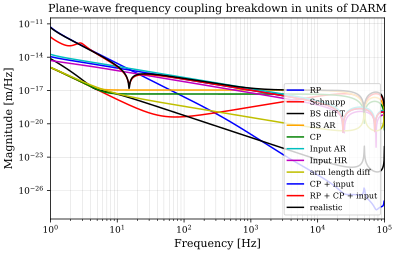

In [59]:
for lbl, sol in traces.items():
    plt.loglog(sol.f, abs(sol["i1.frq", "B1.DC"])/abs(sol["DARM.AC", "B1.DC"]), label=lbl)
    #plt.loglog(sol.f, abs(sol["DARM.AC", "B1.DC"]))
    plt.legend(fontsize=8, loc='lower right')
    
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [m/Hz]")
#plt.ylim(1e-24, None)
plt.title("Plane-wave frequency coupling breakdown in units of DARM", fontsize=11)
plt.savefig("frequency_coupling_plane_wave_contributions.pdf")

# Also consider the realistic model of the ITF

In [60]:
virgo_real = finesse.virgo.Virgo(files_to_parse=['00_virgo_common_file_updated_0607.kat','01_additional_katscript_updated_0607.kat'], display_plots = True,
                           maxtem = "off", verbose = True, parse_additional_katscript=False, add_locks = False,
                            control_scheme={
                "PRCL": ("B2_6", "I", None, 1e-12),
                "SRCL": ("B4_56", "Q", None, 50e-11),
                "DARM": ("B1p_56", "I", None, 1e-16),
                "CARM": ("B4_6", "I", None, 1e-14),
                "MICH": ("B4_56", "I", None, 1e-11),
            })

Parsed input files, 00_virgo_common_file_updated_0607.kat, 01_additional_katscript_updated_0607.kat


In [61]:
virgo_real.model.i1.P = 25

In [62]:
virgo_real.make(dc_lock= True)

Adjusting recycling cavity lengths...
--  adjusting PRC length
    adjusting lPOP_BS.L by 0.0004736 m
--  adjusting SRC length
    adjusting lsr.L by 0.000883 m
Pretuning...
Optimizing demodulation phases...
--  Optimized demodulation phases:
    PRCL     B2_6_I    : phase=169.4772
    SRCL     B4_56_Q   : phase=-43.7503
    DARM     B1p_56_I  : phase= 41.7019
    CARM     B4_6_I    : phase= -5.4545
    MICH     B4_56_I   : phase=-133.7503
--  Suggested lock gains:
    PRCL     B2_6_I    :   0.001799
    SRCL     B4_56_Q   : 0.00027805
    DARM     B1p_56_I  :     95.175
    CARM     B4_6_I    :      4.332
    MICH     B4_56_I   : 0.00054738
Optimizing lock gains...
--  Optimized lock gains:
    PRCL     B2_6_I    :    -555.88
    SRCL     B4_56_Q   :    -3596.4
    DARM     B1p_56_I  :  -0.010507
    CARM     B4_6_I    :   -0.23084
    MICH     B4_56_I   :    -1826.9
Running RF locks...
--  DOFs before locking:
    PRCL: 0.0
    SRCL: 90.0
    DARM: 0.0
    CARM: 0.0
    MICH: 0.0


PRCL_lock ✗ SRCL_lock ✗ DARM_rf_lock ✗ CARM_lock ✗ MICH_lock ✗ |###| 10000/10000

--  DOFs after locking:
    PRCL: 0.0
    SRCL: 89.99999999999999
    DARM: 0.0
    CARM: 0.0
    MICH: 0.0
Switching to DARM DC lock...
--  DOFs before locking:
    PRCL: 0.0
    SRCL: 89.99999999999999
    DARM: 0.0
    CARM: 0.0
    MICH: 0.0


DARM_rf_lock ✗ |###################################################| 10000/10000

DARM_dc_lock ✗ |###################################################| 10000/10000

--  DOFs after locking:
    PRCL: 0.0
    SRCL: 89.99999999999999
    DARM: -0.0011317388809677078
    CARM: 0.0
    MICH: 0.0
Done.


In [63]:
virgo_real.print_tunings()
virgo_real.print_powers()

┌───────────┬────────────┬──────────────┬──────────────┬──────────────┐
│ Optic/DOF │  phi [deg] │ dof.DC [deg] │ Tuning [deg] │  Tuning [pm] │
╞═══════════╪════════════╪══════════════╪══════════════╪══════════════╡
│ NE        │          0 │              │   0.00113174 │      3.34492 │
│ WE        │          0 │              │  -0.00113174 │     -3.34492 │
│ NI        │          0 │              │            0 │            0 │
│ WI        │          0 │              │            0 │            0 │
│ PR        │          0 │              │            0 │            0 │
│ SR        │          0 │              │          -90 │      -266000 │
│ PRCL      │            │            0 │              │              │
│ SRCL      │            │           90 │              │              │
│ DARM      │            │    -0.001132 │              │              │
│ CARM      │            │            0 │              │              │
│ MICH      │            │            0 │              │        

In [64]:
virgo_real.model.run(RunLocks(method = 'newton'))
virgo_real.print_tunings()
virgo_real.print_powers()
print_powers_with_rf(virgo_real)

PRCL_lock ✗ SRCL_lock ✗ DARM_dc_lock ✗ CARM_lock ✗ MICH_lock ✗ |###| 10000/10000

┌───────────┬────────────┬──────────────┬──────────────┬──────────────┐
│ Optic/DOF │  phi [deg] │ dof.DC [deg] │ Tuning [deg] │  Tuning [pm] │
╞═══════════╪════════════╪══════════════╪══════════════╪══════════════╡
│ NE        │          0 │              │   0.00112356 │      3.32073 │
│ WE        │          0 │              │   -0.0011318 │     -3.34509 │
│ NI        │          0 │              │ -4.07494e-06 │   -0.0120437 │
│ WI        │          0 │              │  4.07494e-06 │    0.0120437 │
│ PR        │          0 │              │ -1.95258e-08 │ -5.77096e-05 │
│ SR        │          0 │              │          -90 │      -266000 │
│ PRCL      │            │   -1.953e-08 │              │              │
│ SRCL      │            │           90 │              │              │
│ DARM      │            │    -0.001132 │              │              │
│ CARM      │            │    -4.12e-06 │              │              │
│ MICH      │            │    4.075e-06 │              │        

In [65]:
# realistic transfer function
with virgo_real.model.temporary_parameters():
    out = virgo_real.model.run("series(frequency_response(geomspace(1, 100k, 1000), [i1.frq, DARM.AC], B1.DC, name='freq'), noxaxis())")
    #out = virgo.model.run("series(frequency_response(geomspace(10, 12k, 100),  DARM, B1.DC, name='freq'), noxaxis())")

    traces['realistic'] = out['freq']
    virgo_real.print_tunings()
    virgo_real.print_powers()

/Users/jacquesding/opt/anaconda3/lib/python3.8/site-packages/finesse/analysis/actions/base.py:133: UserWarning: Signal frequency (fsig) was set to None but simulation needs it. Setting default value of 1 Hz
  self.__sim.__enter__()


┌───────────┬────────────┬──────────────┬──────────────┬──────────────┐
│ Optic/DOF │  phi [deg] │ dof.DC [deg] │ Tuning [deg] │  Tuning [pm] │
╞═══════════╪════════════╪══════════════╪══════════════╪══════════════╡
│ NE        │          0 │              │   0.00112356 │      3.32073 │
│ WE        │          0 │              │   -0.0011318 │     -3.34509 │
│ NI        │          0 │              │ -4.07494e-06 │   -0.0120437 │
│ WI        │          0 │              │  4.07494e-06 │    0.0120437 │
│ PR        │          0 │              │ -1.95258e-08 │ -5.77096e-05 │
│ SR        │          0 │              │          -90 │      -266000 │
│ PRCL      │            │   -1.953e-08 │              │              │
│ SRCL      │            │           90 │              │              │
│ DARM      │            │    -0.001132 │              │              │
│ CARM      │            │    -4.12e-06 │              │              │
│ MICH      │            │    4.075e-06 │              │        

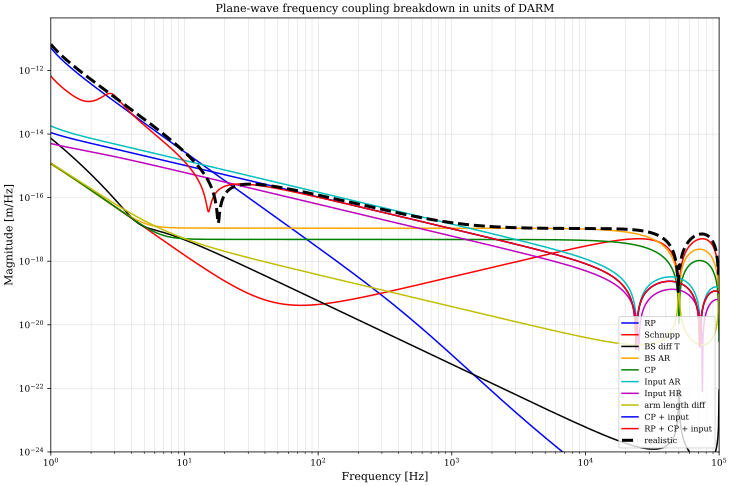

In [66]:
plt.figure(figsize = (12,8))
for lbl, sol in traces.items():
    
    if lbl =='realistic':
        plt.loglog(sol.f, abs(sol["i1.frq", "B1.DC"])/abs(sol["DARM.AC", "B1.DC"]), label=lbl, linestyle = '--',color = 'black', linewidth = 3 )
        #plt.loglog(sol.f, abs(sol["DARM.AC", "B1.DC"]))
        plt.legend(fontsize=8, loc='lower right')
    else:
        plt.loglog(sol.f, abs(sol["i1.frq", "B1.DC"])/abs(sol["DARM.AC", "B1.DC"]), label=lbl)
        #plt.loglog(sol.f, abs(sol["DARM.AC", "B1.DC"]))
        plt.legend(fontsize=8, loc='lower right')
    
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [m/Hz]")
plt.ylim(1e-24, None)
plt.title("Plane-wave frequency coupling breakdown in units of DARM", fontsize=11)
plt.savefig("frequency_coupling_plane_wave_breakdown.png")

array([<AxesSubplot:title={'center':'DARM TF'}, ylabel='Amplitude [$\\sqrt{W}$]'>,
       <AxesSubplot:xlabel='f [Hz]', ylabel='Phase [deg]'>], dtype=object)

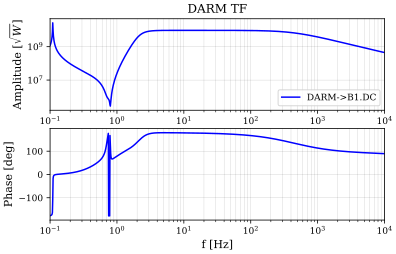

In [67]:
virgo_real.plot_DARM(dof = 'DARM', readout_port = 'B1.DC', axis = [0.1, 10000, 1000])